# Label Only Membership Inference (Revisited on points)

### Threat Model:

- **Black Box** access to an overfitted classifier with no access to actual $D_{train}$
- Predict API returns **only labels instead of confidence vectors**
- We have some insight on the training data distribution, $D_{out}$ , **but** $D_{train} \cap D_{out} = \varnothing$


### Attack Target: 
- Use a shadow model to attack local shadow models and extract membership leakage features
- Use data perturbations in order to exploit test/training data approximation relevancies to the classification boundaries.
- Perfom the boundary-based attack on the actual model

### Evaluation Target
- Score over $50\%$ accuracy
- Train attack model based on this assumption and compare with conf-vector attack

Implemented based on [this paper](https://arxiv.org/abs/2007.14321).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from mia.attack_model import *
from mia.label_only import *
from mia.shadow_models import *
from mia.utilities import *


from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Target Model

### Model Architecture
- 2 layers of 32 $3\times 3$ Conv2D filters with Max Pooling
- 2 layers of 64 $3\times 3$ Conv2D filters with MaxPooling
- Dense Layer of 512 neurons
- Dense Output layer of 10 neurons
- Each layer has ReLU activation


In [6]:
D_TARGET_SIZE = 2500

In [10]:
def f_target(X_train, y_train, X_test=None, y_test=None, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(32, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  if X_test is None or y_test is None:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_split=0.2)
  else:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test))
  return model

In [11]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((-1, 28, 28, 1))
test_images=test_images.reshape((-1, 28, 28, 1))

#shuffle the datasets
sample_i = np.random.choice(range(train_images.shape[0]), train_images.shape[0], replace=False)
train_images = train_images[sample_i]
train_labels = train_labels[sample_i]
sample_i = np.random.choice(range(test_images.shape[0]), test_images.shape[0], replace=False)
test_images = test_images[sample_i]
test_labels = test_labels[sample_i] 

# define the target's training dataset and the attacker's retrieved dataset
attacker_labels = np.concatenate((train_labels[D_TARGET_SIZE:], test_labels))
attacker_images = np.concatenate((train_images[D_TARGET_SIZE:], test_images))
target_images = train_images[:D_TARGET_SIZE]
target_labels = train_labels[:D_TARGET_SIZE]

In [12]:
train_images, eval_images, train_labels, eval_labels = train_test_split(target_images, target_labels, test_size=0.2, shuffle=True)
target_model = f_target(train_images, train_labels, eval_images, eval_labels, epochs=25) 

Epoch 1/25
63/63 [==============================] - 2s 16ms/step - loss: 5.9607 - accuracy: 0.5740 - val_loss: 0.6591 - val_accuracy: 0.8220
Epoch 2/25
63/63 [==============================] - 1s 10ms/step - loss: 0.3382 - accuracy: 0.9000 - val_loss: 0.3604 - val_accuracy: 0.9020
Epoch 3/25
63/63 [==============================] - 1s 11ms/step - loss: 0.1106 - accuracy: 0.9680 - val_loss: 0.3344 - val_accuracy: 0.8940
Epoch 4/25
63/63 [==============================] - 1s 10ms/step - loss: 0.0407 - accuracy: 0.9905 - val_loss: 0.3497 - val_accuracy: 0.9020
Epoch 5/25
63/63 [==============================] - 1s 11ms/step - loss: 0.0201 - accuracy: 0.9960 - val_loss: 0.2844 - val_accuracy: 0.9280
Epoch 6/25
63/63 [==============================] - 1s 14ms/step - loss: 0.0123 - accuracy: 0.9975 - val_loss: 0.2929 - val_accuracy: 0.9280
Epoch 7/25
63/63 [==============================] - 1s 9ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.2875 - val_accuracy: 0.9340
Epoch 8/25
63/

### Perturbed Instance Behaviour

Following we will apply some perturbations to data instances from in and out of $D_{target}$ and we will count how the predicted label change in respect to this perturbations, according to each class.



## Shadow Models
Following we define our own shadow models

### Shadow Model Architecture
- 3 CNN layers of $32, 64, 128$ filters of size $3 \times 3$ with MaxPooling and ReLU activation
- Dense Layer of 128 nodes
- Dense Layer of 10 nodes as Output layer

All output logits pass through Softmax Unit as in the target model to acquire probability vectors



### Shadow Dataset Composition

We just divide the CIFAR-10 dataset to $D_{out}$ and $D_{train}$ such as $D_{train} \cap D_{out} = \varnothing$ and use $D_{out}$ in order to train/test shadow models and attack model.

In [14]:
N_SHADOWS = 5
D_SHADOW_SIZE = 1000

In [16]:
def f_shadow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(32, activation='tanh'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [17]:
def create_shadows(D_shadows):
  shadow_models_batch = ShadowModelBatch(len(D_shadows), f_shadow) # shadow model list
  shadow_models_batch.fit_all(D_shadows, epochs=25)
  return shadow_models_batch # return a list where every item is (model, acc), train-data, test-data

In [18]:
# generate shadow datasets
D_shadows = generate_shadow_dataset(target_model, N_SHADOWS, D_SHADOW_SIZE, 10, attacker_images, attacker_labels)

In [19]:
# train the shadow models
shadow_models = create_shadows(D_shadows)

Epoch 1/25
21/21 [==============================] - 1s 17ms/step - loss: 1.2430 - accuracy: 0.6045 - val_loss: 0.8319 - val_accuracy: 0.7788
Epoch 2/25
21/21 [==============================] - 0s 9ms/step - loss: 0.4951 - accuracy: 0.8851 - val_loss: 0.6166 - val_accuracy: 0.8424
Epoch 3/25
21/21 [==============================] - 0s 10ms/step - loss: 0.2731 - accuracy: 0.9657 - val_loss: 0.5697 - val_accuracy: 0.8545
Epoch 4/25
21/21 [==============================] - 0s 9ms/step - loss: 0.1735 - accuracy: 0.9851 - val_loss: 0.4936 - val_accuracy: 0.8727
Epoch 5/25
21/21 [==============================] - 0s 9ms/step - loss: 0.1197 - accuracy: 0.9955 - val_loss: 0.4680 - val_accuracy: 0.8848
Epoch 6/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0890 - accuracy: 0.9985 - val_loss: 0.4638 - val_accuracy: 0.8818
Epoch 7/25
21/21 [==============================] - 0s 9ms/step - loss: 0.0693 - accuracy: 0.9985 - val_loss: 0.4537 - val_accuracy: 0.8848
Epoch 8/25
21/21 [

## Attack Model

### Attack Model Architecture
The attack model is consisted of 1 swallow layer of 10 neurons just as proposed in Shokri et al. and in the relative label only attack paper.


### Attack Dataset
The attack dataset will be consisted of vectors $x_i$, s.t. $x_i$ contains:
- real label
- predicted label
- bitstring of length $n'$, where $x_{ij+2}, \; j \in \{1, ..., n'\} $ will be 1 if perturbed label is same as predicted, otherwise it'll be zero.


### Perturbed Queries for feature extraction and Attack Dataset

In order to construct the actual attack dataset we have 2 perturbation functions:
- Translate
- Rotate

that can apply the necessary augmentations in order to acquire the feature vector for a query.

This works by applying all augmentations to the input X and querying the target model in order to return a binary vector $x_{attack}$ where $$x_{attack_p} = 1 \; if \;y_p == y_{true} \; else \; 0, \forall p \in Perturbations(X)$$

where $y_p$ is the label for pertubation $p$ of input $X$.

In [30]:
r = 3 # rotate range => creating 2*r+1 rotations 
d = 1 # translate range =? creating 4*d + 1 translates

In [31]:
# input dims = 2*r(# of rotates - neutral)  + 4*d(# of translates - neutral) + 2 (y_pred, y_true)
attack_model = LabelOnlyAttackModel(shadow_models, 10, (2*r+4*d+2,), 'adam')

In [32]:
# provide the model with the perturbation parameters and use @prepare_batch to apply them and 
# return attack input instance from a picture that the model will recognise
attack_model.fit(r, d, epochs=50)

Preparing shadow batch of size 660
Done!
Preparing shadow batch of size 660
Done!
Preparing shadow batch of size 660
Done!
Preparing shadow batch of size 660
Done!
Preparing shadow batch of size 660
Done!
Epoch 1/50
73/73 [==============================] - 1s 7ms/step - loss: 0.7551 - accuracy: 0.5035 - val_loss: 0.7236 - val_accuracy: 0.4636
Epoch 2/50
73/73 [==============================] - 0s 5ms/step - loss: 0.7360 - accuracy: 0.5087 - val_loss: 0.7161 - val_accuracy: 0.5374
Epoch 3/50
73/73 [==============================] - 0s 5ms/step - loss: 0.7262 - accuracy: 0.5411 - val_loss: 0.7093 - val_accuracy: 0.4909
Epoch 4/50
73/73 [==============================] - 0s 5ms/step - loss: 0.7237 - accuracy: 0.5100 - val_loss: 0.7049 - val_accuracy: 0.5273
Epoch 5/50
73/73 [==============================] - 0s 5ms/step - loss: 0.7162 - accuracy: 0.5221 - val_loss: 0.7064 - val_accuracy: 0.5394
Epoch 6/50
73/73 [==============================] - 0s 5ms/step - loss: 0.7100 - accuracy: 0.52

## Attack Evaluation

Use prepare batch to transform the evaluation dataset and give it to the model.

If previously fitted prepare batch will already have a value for $r$ and $d$ of pertubations, otherwise the user might set them with the following snippet.

In [33]:
# attack_model.r = 2
# attack_model.d = 1

In [34]:
D_in = attack_model.prepare_batch(target_model, train_images[:500], train_labels[:500], True)

In [35]:
D_out = attack_model.prepare_batch(target_model, attacker_images[:500], attacker_labels[:500], False)

class-1 acc: 0.5208333134651184
class-2 acc: 0.4909090995788574
class-3 acc: 0.6145833134651184
class-4 acc: 0.4545454680919647
class-5 acc: 0.5098039507865906
class-6 acc: 0.5
class-7 acc: 0.48695650696754456
class-8 acc: 0.5744680762290955
class-9 acc: 0.5473684072494507
class-10 acc: 0.5567010045051575
              precision    recall  f1-score   support

         0.0       0.58      0.18      0.27       500
         1.0       0.51      0.87      0.65       500

    accuracy                           0.52      1000
   macro avg       0.55      0.52      0.46      1000
weighted avg       0.55      0.52      0.46      1000

AUC: 0.5144040000000001


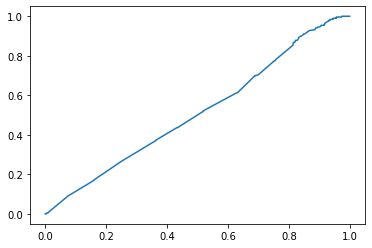

In [36]:
attack_model.evaluate(np.concatenate((D_out[:, :-1], D_in[:, :-1])),  np.concatenate((D_out[:, -1], D_in[:, -1])), 10)

# Extras

## Check target model's behaviour in perturbed images

In [37]:
def study_perturbations(model, X, y, rs, ts):
  diffs = []
  y_pred = target_predict(model, X)    
  for c in range(10):
    #  given class acquire the changes in perturbed input instances given the model
    idx = y_pred[:, 0] == c
    X_c = X[idx]
    y_pred_c = y_pred[idx]
    perturbed_labels = augmented_queries(model, X_c, y_pred_c, rs, ts)
    # Now we have to count how many labels diverge from the predicted label
    diff = len(perturbed_labels.reshape(-1)) - sum(perturbed_labels.reshape(-1)) # the labels are binary where 1 == y_pred = y_perturbed, otherwise 0
    diffs.append(int(100 * diff/len(perturbed_labels.reshape(-1)))) # append the percentage of changes in the class sample
    
  return diffs 

In [38]:
N_SAMPLES = 100
train_idx = np.random.choice(range(train_images.shape[0]), N_SAMPLES, replace=False)
test_idx = np.random.choice(range(attacker_images.shape[0]), N_SAMPLES, replace=False)

 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%')]

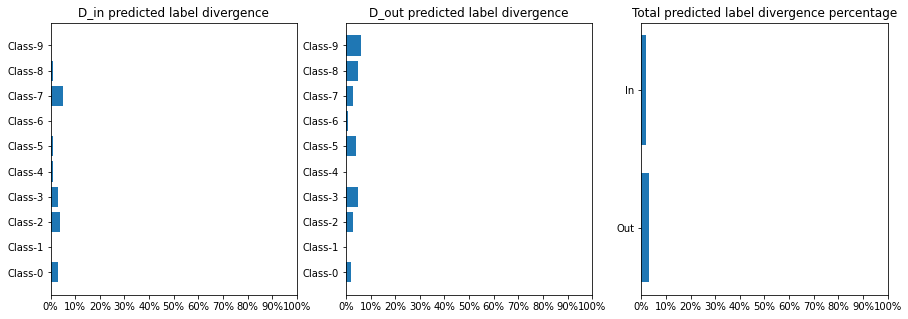

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])

We can conclude that $x \in D_{target}$ are more robust to perturbations, than any other instance not in target's training dataset. Nevertheless, whether the model is overfitted or not plays an important role to this training feature, meaning that the more overfit the model is the easier it gets to infer membership of tested instances. 

## Attack a perturbation trained model

- We will apply augmentations to the dataset and re-train the target model.
- The attacker **does not** know our augmentation settings, so he will train with a normal dataset of zero augmentations
- We want to measure the quality of the attack when the target tries to defend MIAs by adding perturbed images of data samples 

In [40]:
# We will defend against the same rotations and translations that the attack models uses (worst case for the attacker)
rotates = create_rotates(r)
translates = create_translates(d)

X_train_aug = train_images
X_eval_aug = eval_images
y_train_aug = np.concatenate(tuple([train_labels] + [train_labels for rot in rotates] + [train_labels for tra in translates]))
y_eval_aug = np.concatenate(tuple([eval_labels] + [eval_labels for rot in rotates] + [eval_labels for tra in translates]))



for rot in rotates:
  aug_x = apply_augment(train_images, rot, 'r')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, rot, 'r')
  X_eval_aug = np.concatenate((X_eval_aug,aug_x))

for tra in translates:
  aug_x = apply_augment(train_images, tra, 'd')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, tra, 'd')
  X_eval_aug = np.concatenate((X_eval_aug ,aug_x))


In [41]:

with tf.device('/gpu:0'):
  X_train_aug = tf.convert_to_tensor(X_train_aug)
  y_train_aug = tf.convert_to_tensor(y_train_aug)
  X_eval_aug = tf.convert_to_tensor(X_eval_aug)
  y_eval_aug = tf.convert_to_tensor(y_eval_aug)
  target_model = f_target(X_train_aug, y_train_aug, X_eval_aug, y_eval_aug, epochs=10) 

Epoch 1/10
813/813 [==============================] - 7s 8ms/step - loss: 0.5658 - accuracy: 0.8776 - val_loss: 0.3183 - val_accuracy: 0.9285
Epoch 2/10
813/813 [==============================] - 7s 8ms/step - loss: 0.0431 - accuracy: 0.9873 - val_loss: 0.2774 - val_accuracy: 0.9457
Epoch 3/10
813/813 [==============================] - 6s 8ms/step - loss: 0.0287 - accuracy: 0.9914 - val_loss: 0.4475 - val_accuracy: 0.9345
Epoch 4/10
813/813 [==============================] - 6s 8ms/step - loss: 0.0219 - accuracy: 0.9942 - val_loss: 0.2932 - val_accuracy: 0.9551
Epoch 5/10
813/813 [==============================] - 5s 7ms/step - loss: 0.0214 - accuracy: 0.9942 - val_loss: 0.4889 - val_accuracy: 0.9414
Epoch 6/10
813/813 [==============================] - 5s 7ms/step - loss: 0.0195 - accuracy: 0.9943 - val_loss: 0.4097 - val_accuracy: 0.9483
Epoch 7/10
813/813 [==============================] - 6s 7ms/step - loss: 0.0164 - accuracy: 0.9961 - val_loss: 0.4123 - val_accuracy: 0.9522
Epoch 

The model is quite overfitted so now all that is left is to evaluate the attack model we created before on the newly trained and "defended" target model with perturbations in the train dataset.

class-1 acc: 0.5206185579299927
class-2 acc: 0.467980295419693
class-3 acc: 0.5550239086151123
class-4 acc: 0.5291262269020081
class-5 acc: 0.521276593208313
class-6 acc: 0.5485714077949524
class-7 acc: 0.5069124698638916
class-8 acc: 0.5906976461410522
class-9 acc: 0.621052622795105
class-10 acc: 0.5812807679176331
              precision    recall  f1-score   support

         0.0       0.83      0.11      0.19      1000
         1.0       0.52      0.98      0.68      1000

    accuracy                           0.54      2000
   macro avg       0.68      0.54      0.44      2000
weighted avg       0.68      0.54      0.44      2000

AUC: 0.5257385


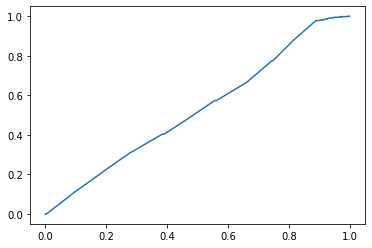

In [42]:
D_in = attack_model.prepare_batch(target_model, train_images[:1000], train_labels[:1000], True)

D_out = attack_model.prepare_batch(target_model, attacker_images[:1000], attacker_labels[:1000], False)

attack_model.evaluate(np.concatenate((D_out[:, :-1], D_in[:, :-1])),  np.concatenate((D_out[:, -1], D_in[:, -1])), 10)

### Conclusion

To conclude if the model is more vulnerable, we must meassure the label divergence percentage in the adjusted-to-augmentations model.

 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%')]

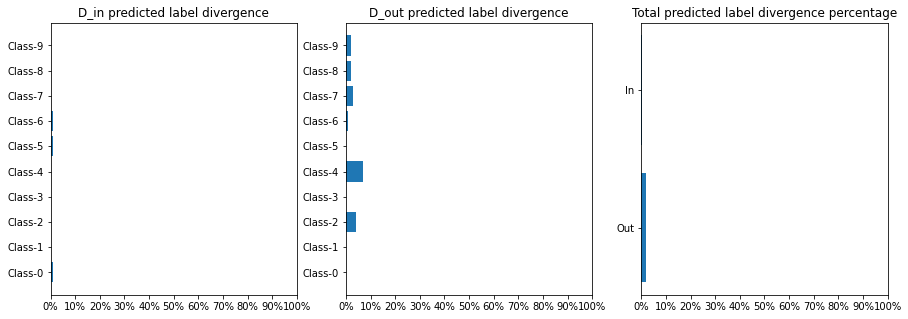

In [43]:
# test it onthe same data as we tested the non-adjusted to augmentation model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])

We can see that the general percentage of predicted label divergence has fallen, **but** the confidence of the ML algorithm in predicting the label of perturbed instances of instances in $D_{target}$ is better that before and that is realized by the increase of the AUC value (~0.52 when before ~0.51). This means that the adjusted model is even more vulnerable and our attack predicts membership with high sensitivity to the predicted label changes. Next step is to run all with some defences on.